In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import math
import torch.nn.functional as F
import os
import csv
import cv2

/home/hoge/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# alphabet_list = [[30, 600, 1568, 709, 802, 816, 1258, 426], [579, 867, 1385, 53, 356, 431, 669, 763], [166, 245, 844, 1065, 1255, 1286, 137], [288, 1056, 1123, 1160, 1268, 920, 1039, 1508], [1201, 1225, 542, 1016, 150, 223, 254, 431], [1129, 1879, 66, 271, 262, 732, 807], [466, 105, 1084, 91, 251, 789, 1542, 1935], [1690, 1902, 311, 371, 970, 1514, 1538, 1924], [7, 255, 400, 751, 794, 876, 22, 92], [124, 187, 896, 1180, 1250, 1587, 1604, 1635], [1502, 100, 181, 1231, 1234, 80, 245, 409], [1569, 363, 1101, 1316, 1439, 1863, 730, 832], [291, 133, 173, 274, 904, 1023, 1085, 1449], [151, 149, 587, 820, 1099, 1459, 1483, 1698], [105, 1270, 1576, 32, 405, 831, 968, 1527], [310, 934, 1976, 288, 400, 689, 807, 1536], [396, 862, 1105, 45, 170, 495, 791, 1064], [1182, 784, 1096, 18, 867, 918, 968, 971], [1487, 1569, 772, 182, 281, 414, 447, 1775], [142, 623, 145, 182, 1831, 148, 214, 1466], [1174, 13, 274, 533, 745, 1277, 1325, 1875], [1009, 51, 113, 245, 482, 730, 1344, 1633], [1351, 340, 978, 22, 1698, 1943, 322, 777], [282, 714, 1384, 1516, 1557, 1610, 90, 778], [687, 668, 930, 1673, 1956, 32, 53, 110], [1992, 103, 188, 501, 892, 1558, 1660, 1931]]
# for i, alpha in enumerate(alphabet_list):
#     os.makedirs("../GAN+classifier_c1e-6/strong/" + chr(i + 65), exist_ok=True)
#     images = []
#     for j in alpha:
#         img_array = cv2.imread("../GAN+classifier_c1e-6/org/" + chr(i + 65) + "/{}.png".format(j), cv2.IMREAD_GRAYSCALE)  # 画像読み込み
#         plt.xticks([], [])
#         plt.yticks([], [])
#         plt.imsave("../GAN+classifier_c1e-6/strong/" + chr(i + 65) + "/{}.png".format(j), img_array, cmap="gray")

In [3]:
import random
import numpy as np
import torch

def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True


torch_fix_seed()

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('torch version:',torch.__version__)
print('device:', device)

torch version: 1.11.0+cu113
device: cuda


In [5]:
img_size = 64 # Image size
batch_size = 16  # Batch size

# Model
z_size = 100
ngf = 32
ndf = 64
generator_layer_size = [256, 512, 1024, 2048]
discriminator_layer_size = [2048, 1024, 512, 256]

# Training
epochs = 100 # Train epochs
learning_rate_G = 2e-5
learning_rate_D = 1e-5

In [6]:
class_list = [chr(i + 65) for i in range(26)]
class_num = len(class_list)

In [7]:
def onehot_encode(label, n_class=26):  
    # ラベルをOne-Hoe形式に変換
    eye = torch.eye(n_class).to(device)
    # ランダムベクトルあるいは画像と連結するために(B, c_class, 1, 1)のTensorにして戻す
    return eye[label].view(-1, n_class, 1, 1)
    
def concat_image_label(image, label, n_class=26):
    # 画像とラベルを連結する
    oh_label = onehot_encode(label, n_class).to(device)       # ラベルをOne-Hot形式に変換
    oh_label = oh_label.expand(16, n_class, 64, 64)  # ラベルを画像サイズに拡大
    return torch.cat((image, oh_label), dim=1)    # 画像とラベルをチャネル方向（dim=1）で連結
 
def concat_noise_label(noise, label, n_class=26):
    # ランダムベクトルとラベルを連結する
    oh_label = onehot_encode(label, n_class).to(device)     # ラベルをOne-Hot形式に変換
    return torch.cat((noise, oh_label), dim=1)  # ランダムベクトルとラベルを連結

In [8]:
class Generator(nn.Module):
    def __init__(self, generator_layer_size, z_size, img_size, class_num):
        super().__init__()
        
        self.z_size = z_size
        self.img_size = img_size
        
        # self.label_emb = nn.Embedding(class_num, class_num)
        
        self.model = nn.Sequential(
            nn.ConvTranspose2d(self.z_size + 26, ngf * 32, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 32),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 32, ngf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, 1, 3, 1, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        
        # Reshape z
        # z = z.view(-1, self.z_size)
        
        # One-hot vector to embedding vector
        # c = self.label_emb(labels)
        
        # Concat image & label
        # x = torch.cat([z, c], 1)

        x = concat_noise_label(z, labels)


        # rlabels_list = []
        # for label in rlabels:
        #     l = torch.Tensor([[[label.item()]]])
        #     rlabels_list.append(l)
        # rlabels_list = torch.stack(rlabels_list).to(device)

        # x = torch.cat((x, rlabels_list), dim=1)
        
        # Generator out
        out = self.model(x)
        
        return out
        # return out.view(-1, self.img_size, self.img_size)

In [9]:
generator1 = Generator(generator_layer_size, z_size, img_size, class_num).to(device)
generator2 = Generator(generator_layer_size, z_size, img_size, class_num).to(device)
# generator.load_state_dict(torch.load("generator+reg_hinge20.pth", map_location='cpu'))

In [10]:
pretrained_model = "googlefonts.pth"
use_cuda = True
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(57600, 128)
        self.fc2 = nn.Linear(128, 26)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# MNISTのTest datasetと dataloaderの定義
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize((0.5,), (0.5,))
#             ])), 
#         batch_size=1, shuffle=False)

# 使うデバイス（CPUかGPUか）の定義
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# ネットワークの初期化
model = Net().to(device)
print(model)
# 訓練済みモデルのロード
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
model.eval()

CUDA Available:  True
Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=57600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=26, bias=True)
)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=57600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=26, bias=True)
)

In [11]:
class rNet(nn.Module):
    def __init__(self):
        super(rNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(57600, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x
# 使うデバイス（CPUかGPUか）の定義
rmodel_list = []
for i in range(26):
    pretrained_model = "../GoogleFonts_reg/model/reg_" + chr(i + 65) + ".pth"
    # ネットワークの初期化
    rmodel = rNet().to(device)
    # 訓練済みモデルのロード
    rmodel.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
    # モデルを評価モードに設定。本チュートリアルの例では、これはドロップアウト層等を評価モードにするのに必要
    rmodel.eval()
    rmodel_list.append(rmodel)

In [12]:
class ImageTransform():
  def __init__(self, mean, std):
    self.data_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize(mean, std)
    ])

  def __call__(self, img):
    return self.data_transform(img)

In [13]:
mean = (0.5,)
std = (0.5,)
images = ImageFolder( "../GoogleFonts/all", transform = ImageTransform(mean, std))
data_loader = DataLoader(images, batch_size=500, shuffle = True, drop_last=True)

In [14]:
def attack(data, data_grad, target, epsilon, lim):
    for i in range(1, 1001):
        data.requires_grad = False
        sign_data_grad = data_grad.sign()
        perturbed_data = data + epsilon * sign_data_grad
        perturbed_data = torch.clamp(perturbed_data, -1, 1)
        data = perturbed_data
        data.requires_grad = True
        output = model(data)
        loss = F.nll_loss(output, target)
        pred = output.max(1, keepdim=True)[1]
        if pred.item() != target.item():
            break
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
    return data, pred, i

In [15]:
# for i in range(1, 101):
#     os.makedirs("../GAN+classifier_c1e-6/hist/{}".format(i), exist_ok=True)
#     os.makedirs("../GAN+classifier_c1e-7/hist/{}".format(i), exist_ok=True)


# all_list1 = []
# all_list2 = []
# for para in range(1, 101):
#     generator1.load_state_dict(torch.load("../GAN+classifier_c1e-6/model/{}.pth".format(para), map_location='cpu'))
#     generator2.load_state_dict(torch.load("../GAN+classifier_c1e-7/model/{}.pth".format(para), map_location='cpu'))
#     if para == 1:
#         all_real = []
#         all_real_mean = []
plt.rcParams["font.size"] = 25
real_hist_mean = []
real_hist_var = []
hist_mean = []
hist_var = []
all_real_list = []
all_list1 = []
for alphabet in range(26):

    print(chr(alphabet + 65))
    # generator1.load_state_dict(torch.load("../GAN+classifier_c1e-6/model/18.pth", map_location='cpu'))
    generator1.load_state_dict(torch.load("../GAN+classifier_c1e-6/model/18.pth", map_location='cpu'))

    l1 = os.listdir("../normalPGD_googlefonts/progress/" + chr(alphabet + 65))
    real_list = []
    for j in l1:
        all_real_list.append(sum(os.path.isfile(os.path.join("../normalPGD_googlefonts/progress/" + chr(alphabet + 65) + "/" + j, name)) for name in os.listdir("../normalPGD_googlefonts/progress/" + chr(alphabet + 65) + "/" + j)))
        real_list.append(sum(os.path.isfile(os.path.join("../normalPGD_googlefonts/progress/" + chr(alphabet + 65) + "/" + j, name)) for name in os.listdir("../normalPGD_googlefonts/progress/" + chr(alphabet + 65) + "/" + j)))
        if len(real_list) == 1000:
            # all_real_mean.append(np.mean(real_list))
            # all_real.append(real_list)
            break

    real_hist_mean.append(np.mean(real_list))
    real_hist_var.append(np.var(real_list))
    # print(np.mean(real_list))
    # plt.ylim(0, 200)
    # plt.hist(real_list, range=(0, 40), bins = 40, alpha = 0.5, label="real images")
    # plt.xlabel("estimated resistance")
    # plt.ylabel("samples")
    # plt.legend(loc='upper left')
    # plt.savefig("../normalPGD_googlefonts/hist/hist_" + chr(alphabet + 65) + ".png", facecolor="white")
    # plt.show()


    z = Variable(torch.randn(1200, z_size, 1, 1)).to(device)
    # Labels 0 ~ 9
    labels = Variable(torch.LongTensor(np.zeros(1200) + alphabet)).to(device)
    # Generating images
    sample_images1 = generator1(z, labels).data.to("cpu")
    # sample_images2 = generator2(z, labels).data.to("cpu")

    list1 = []
    false = 0
    for image, label in zip(sample_images1, labels):
        image, label = image.unsqueeze(0).to(device), label.unsqueeze(0).type(torch.LongTensor).to(device)
        image.requires_grad = True
        # データをモデルに順伝播させます
        output = model(image)
        init_pred = output.max(1, keepdim=True)[1] # 最大の確率のインデックスを取得します。
        # 最初から予測が間違っている場合、攻撃する必要がないため次のイテレーションに進みます。
        if init_pred.item() != label.item():
            continue
        # 損失を計算します
        loss = F.nll_loss(output, label)
        # 既存の勾配を全てゼロにします
        model.zero_grad()
        # 逆伝播させてモデルの勾配を計算します
        loss.backward()
        # データの勾配を取得します
        data_grad = image.grad.data
        perturbed_data, pred, resistance = attack(image, data_grad, label, 0.02, 0)
        list1.append(resistance)
        all_list1.append(resistance)
        if len(list1) == 1000:
            # all_list1.append(np.mean(list1))
            break

    print(np.mean(list1))
    hist_mean.append(np.mean(list1))
    hist_var.append(np.var(list1))
    # plt.figure(figsize=(12, 8))
    # plt.xlim(0, 40)
    # plt.ylim(0, 400)
    # plt.hist(real_list, range=(0, 40), bins = 40, alpha = 0.5, label="Real images")
    # plt.hist(list1, range=(0, 40), bins = 40, alpha = 0.5, label="Reconstructed images")
    # plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    # plt.tick_params(bottom=False, left=False, right=False, top=False)
    # plt.xticks([k * 10 for k in range(5)])
    # plt.yticks([i * 100 for i in range(5)])
    # plt.grid()
    # # plt.xlabel("Defensibility")
    # # plt.ylabel("Samples")
    # # plt.legend(loc='upper left')
    # plt.savefig("../GAN+classifier_c1e-6/hist_" + chr(alphabet + 65) + ".png", facecolor="white", bbox_inches='tight', pad_inches=0.1)
    # plt.show()

    # list2 = []
    # false = 0
    # for image, label in zip(sample_images2, labels):
    #     image, label = image.unsqueeze(0).to(device), label.unsqueeze(0).type(torch.LongTensor).to(device)
    #     image.requires_grad = True
    #     output = model(image)
    #     init_pred = output.max(1, keepdim=True)[1] # 最大の確率のインデックスを取得します。
    #     # 最初から予測が間違っている場合、攻撃する必要がないため次のイテレーションに進みます。
    #     if init_pred.item() != label.item():
    #         continue
    #     # 損失を計算します
    #     loss = F.nll_loss(output, label)
    #     # 既存の勾配を全てゼロにします
    #     model.zero_grad()
    #     # 逆伝播させてモデルの勾配を計算します
    #     loss.backward()
    #     # データの勾配を取得します
    #     data_grad = image.grad.data
    #     perturbed_data, pred, resistance = attack(image, data_grad, label, 0.02, 0)
    #     list2.append(resistance)
    #     if len(list2) == 1000:
    #         all_list2.append(np.mean(list2))
    #         break
    # print(np.mean(list2))
    # print(len(list2))
    # plt.ylim(0, 200)
    # plt.hist(list2, range=(0, 50), bins = 50, alpha = 0.5, label="1e-7")
    # plt.xlabel("estimated resistance")
    # plt.ylabel("samples")
    # plt.legend(loc='upper left')
    # plt.savefig("../GAN+classifier_c1e-7/hist/{}/hist_".format(para) + chr(alphabet + 65) + ".png", facecolor="white")
    # plt.show()
        
    # if para == 1:
    #     with open("../normalPGD_googlefonts/real.csv", 'w', newline='') as file:
    #         writer = csv.writer(file)
    #         writer.writerows(all_real)
    #         file.close()
# with open("../GAN+classifier_c1e-6/hist_mean_real.csv", 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(real_hist_mean)
#     file.close()

with open("../GAN+classifier_c1e-6/original_image_mean_var.csv", 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows([real_hist_mean, real_hist_var])
    file.close()

with open("../GAN+classifier_c1e-6/GAN+classifier_mean_var.csv", 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows([hist_mean, hist_var])
    file.close()


    
# plt.figure(figsize=(12, 8))
# plt.xlim(0, 40)
# plt.ylim(0, 2000)
# plt.hist(all_real_list, range=(0, 40), bins = 40, alpha = 0.5, label="Real images")
# plt.hist(all_list1, range=(0, 40), bins = 40, alpha = 0.5, label="Reconstructed images")
# plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
# plt.tick_params(bottom=False, left=False, right=False, top=False)
# plt.xticks([k * 10 for k in range(5)])
# plt.yticks([i * 100 for i in range(5)])
# plt.savefig("../GAN+classifier_c1e-6/hist_all.png", facecolor="white", bbox_inches='tight', pad_inches=0.1)
# plt.show() 

    # print(chr(alphabet + 65))

    # print(np.mean(real_list))
    # print(len(real_list))
    # plt.ylim(0, 120)
    # plt.hist(real_list, range=(0, 40), bins = 30, alpha = 0.5, label="real images")
    # plt.xlabel("estimated resistance")
    # plt.ylabel("samples")
    # plt.legend(loc='upper left')
    # plt.savefig("hist_{}.png", facecolor="white")
    # plt.show()


    # print(np.mean(list1))
    # print(len(list1))
    # plt.ylim(0, 120)
    # plt.hist(list1, range=(0, 40), bins = 30, alpha = 0.5, label="1e-6")
    # plt.xlabel("estimated resistance")
    # plt.ylabel("samples")
    # plt.legend(loc='upper left')
    # # plt.savefig("GAN_hist_real_gen.png", facecolor="white")
    # plt.show()

    # print(np.mean(list2))
    # print(len(list2))
    # plt.ylim(0, 120)
    # plt.hist(list2, range=(0, 40), bins = 30, alpha = 0.5, label="1e-7")
    # plt.xlabel("estimated resistance")
    # plt.ylabel("samples")
    # plt.legend(loc='upper left')
    # # plt.savefig("GAN_hist_real_gen.png", facecolor="white")
    # plt.show()

    # plt.ylim(0, 120)
    # plt.hist(real_list, range=(0, 40), bins = 30, alpha = 0.5, label="real images")
    # plt.hist(list1, range=(0, 40), bins = 30, alpha = 0.5, label="1e-6")
    # plt.hist(list2, range=(0, 40), bins = 30, alpha = 0.5, label="1e-7")
    # plt.xlabel("estimated resistance")
    # plt.ylabel("samples")
    # plt.legend(loc='upper left')
    # # plt.savefig("GAN_hist_real_gen+reg.png", facecolor="white")
    # plt.show()

# z = Variable(torch.randn(26 * 5, z_size, 1, 1)).to(device)

# # Labels 0 ~ 9
# labels = Variable(torch.LongTensor([i for _ in range(5) for i in range(class_num)])).to(device)

# sample_images2 = generator2(z, labels)

# sample_images2 = sample_images2.data.cpu()
# grid = make_grid(sample_images2, nrow=26, normalize=True).permute(1,2,0).numpy()
# fig, ax = plt.subplots(figsize=(26,26))
# plt.imshow(grid)
# plt.savefig('generator+reg_hinge25.png')

A
24.748
B
19.069
C
22.068
D
21.261
E
18.566
F
23.937
G
22.776
H
23.873
I
22.569
J
23.195
K
21.318
L
25.114
M
19.475
N
22.372
O
16.564
P
22.221
Q
22.988
R
20.798
S
21.148
T
22.827
U
19.02
V
20.303
W
23.418
X
16.652
Y
23.852
Z
25.04


In [16]:
# plt.figure(figsize=(12, 8))
# plt.xlim(0, 40)
# plt.ylim(0, 3500)
# plt.hist(all_real_list, range=(0, 40), bins = 40, alpha = 0.5, label="Real images")
# plt.hist(all_list1, range=(0, 40), bins = 40, alpha = 0.5, label="Reconstructed images")
# plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
# plt.tick_params(bottom=False, left=False, right=False, top=False)
# plt.xticks([k * 10 for k in range(5)])
# plt.yticks([i * 500 for i in range(7)])
# plt.grid()
# plt.savefig("../GAN+classifier_c1e-6/hist_all.png", facecolor="white", bbox_inches='tight', pad_inches=0.1)
# plt.show() 

In [17]:
# with open("../GAN+classifier_c1e-6/defensibility/{}.csv".format(1), 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(np.array(all_list1))
#     file.close()

In [18]:
grid = make_grid(sample_images2, nrow=26, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(26,10))
plt.imshow(grid)
# plt.savefig('generator+reg_hinge25.png')

NameError: name 'sample_images2' is not defined

: 

torch.Size([5000, 1, 64, 64])
4993


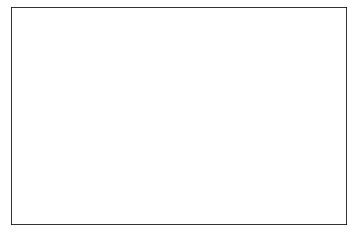

In [ ]:
# z = Variable(torch.randn(5000, z_size, 1, 1)).to(device)

# # Labels 0 ~ 9
# labels = Variable(torch.LongTensor(np.zeros(5000) + 3)).to(device)

# sample_images3 = generator2(z, labels)

# sample_images3 = sample_images3.data.cpu()
# print(sample_images3.shape)
# for k in ["strong", "soso", "weak"]:
#     for c in [chr(i) for i in range(65, 65+26)]:
#             os.makedirs("gen_result/" + k + "/" + c, exist_ok=True)
# count = 0
# for index, (image, label) in enumerate(zip(sample_images3, labels)):
    
#     image, label = image.unsqueeze(0).to(device), label.unsqueeze(0).type(torch.LongTensor).to(device)

#     # データをモデルに順伝播させます
#     output = model(image)
#     init_pred = output.max(1, keepdim=True)[1] # 最大の確率のインデックスを取得します。

#     # 最初から予測が間違っている場合、攻撃する必要がないため次のイテレーションに進みます。
    
#     if init_pred.item() != label.item():
#         false += 1
#         continue
#     count += 1
#     if rmodel_list[label.item()](image).item() > 25:
#         plt.xticks([], [])
#         plt.yticks([], [])
#         plt.imsave("gen_result/strong/" + chr(init_pred.item() + 65) + "/{}.png".format(index), image.squeeze().detach().cpu().numpy(), cmap="gray")
#     elif rmodel_list[label.item()](image).item() > 20:
#         plt.xticks([], [])
#         plt.yticks([], [])
#         plt.imsave("gen_result/soso/" + chr(init_pred.item() + 65) + "/{}.png".format(index), image.squeeze().detach().cpu().numpy(), cmap="gray")
#     elif rmodel_list[label.item()](image).item() <= 20:
#         plt.xticks([], [])
#         plt.yticks([], [])
#         plt.imsave("gen_result/weak/" + chr(init_pred.item() + 65) + "/{}.png".format(index), image.squeeze().detach().cpu().numpy(), cmap="gray")
#     reg_list1.append(rmodel_list[label.item()](image).item())
# print(count)

In [ ]:
# grid = make_grid(sample_images, nrow=26, normalize=True).permute(1,2,0).numpy()
# fig, ax = plt.subplots(figsize=(22,3))
# plt.imshow(grid)
# plt.savefig('generator+reg_hinge20.png')